In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, ward
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter
from matplotlib.pyplot import rc_context
from scipy.ndimage import gaussian_filter1d

In [2]:
adata = sc.read_10x_mtx('./', var_names='gene_symbols', cache=True)
adata

AnnData object with n_obs × n_vars = 11009 × 36601
    var: 'gene_ids', 'feature_types'

In [3]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
adata = adata[adata.obs.total_counts > 6000, :]
adata = adata[adata.obs.total_counts < 30000, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata

C:\Users\YAMAN\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 9096 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'

In [4]:
genes=np.load('SMD_GeneNames.npy',allow_pickle=True)
x=adata.var_names.values
cnt=0;
bimodal_genes=np.zeros((x.shape), dtype=bool)
for i in x:
    if i in genes:
        bimodal_genes[cnt]=1
    else:
        bimodal_genes[cnt]=0
    cnt=cnt+1  
data = adata[:,bimodal_genes]
cluster=np.load('SMD_Matrix.npy')
exclude=np.array(['HIST1H1C','HIST1H1B','HIST1H1E','HIST1H2AH','HIST1H3B','HIST1H3D','CCNB1','HMMR','DLGAP5','UBEC2C','ASPM','MKI67','TOP2A',
                  'CCNB2','CDC20','TUBA1C','KIF14','CENPE','PLK1','PIF1','AURKA','SGO2','UBE2C','NOC2L','IL17RD','UGT8','SLC2A3',
                 'STXBP6','SNHG3','SNHG9','SNHG19','TXNIP','CGNL1','AL118516.1','AC068587.4','AL359091.1','MIAT','APELA','SCUBE2'])
x=adata.var_names.values
cnt=0;
bimodal_genes=np.zeros((x.shape), dtype=bool)
for i in x:
    if i in genes:
        bimodal_genes[cnt]=1
    else:
        bimodal_genes[cnt]=0
    
    if np.sum(i ==exclude):
        bimodal_genes[cnt]=0
    cnt=cnt+1
bimodal_genes2=np.ones((genes.shape), dtype=bool)
cnt=0;
for i in genes:
    if np.sum(i ==exclude):
        bimodal_genes2[cnt]=0
    cnt=cnt+1
bimodal_genes2=np.ndarray.flatten(bimodal_genes2)
clusterX=cluster[:,bimodal_genes2]
geneNames=x[bimodal_genes]

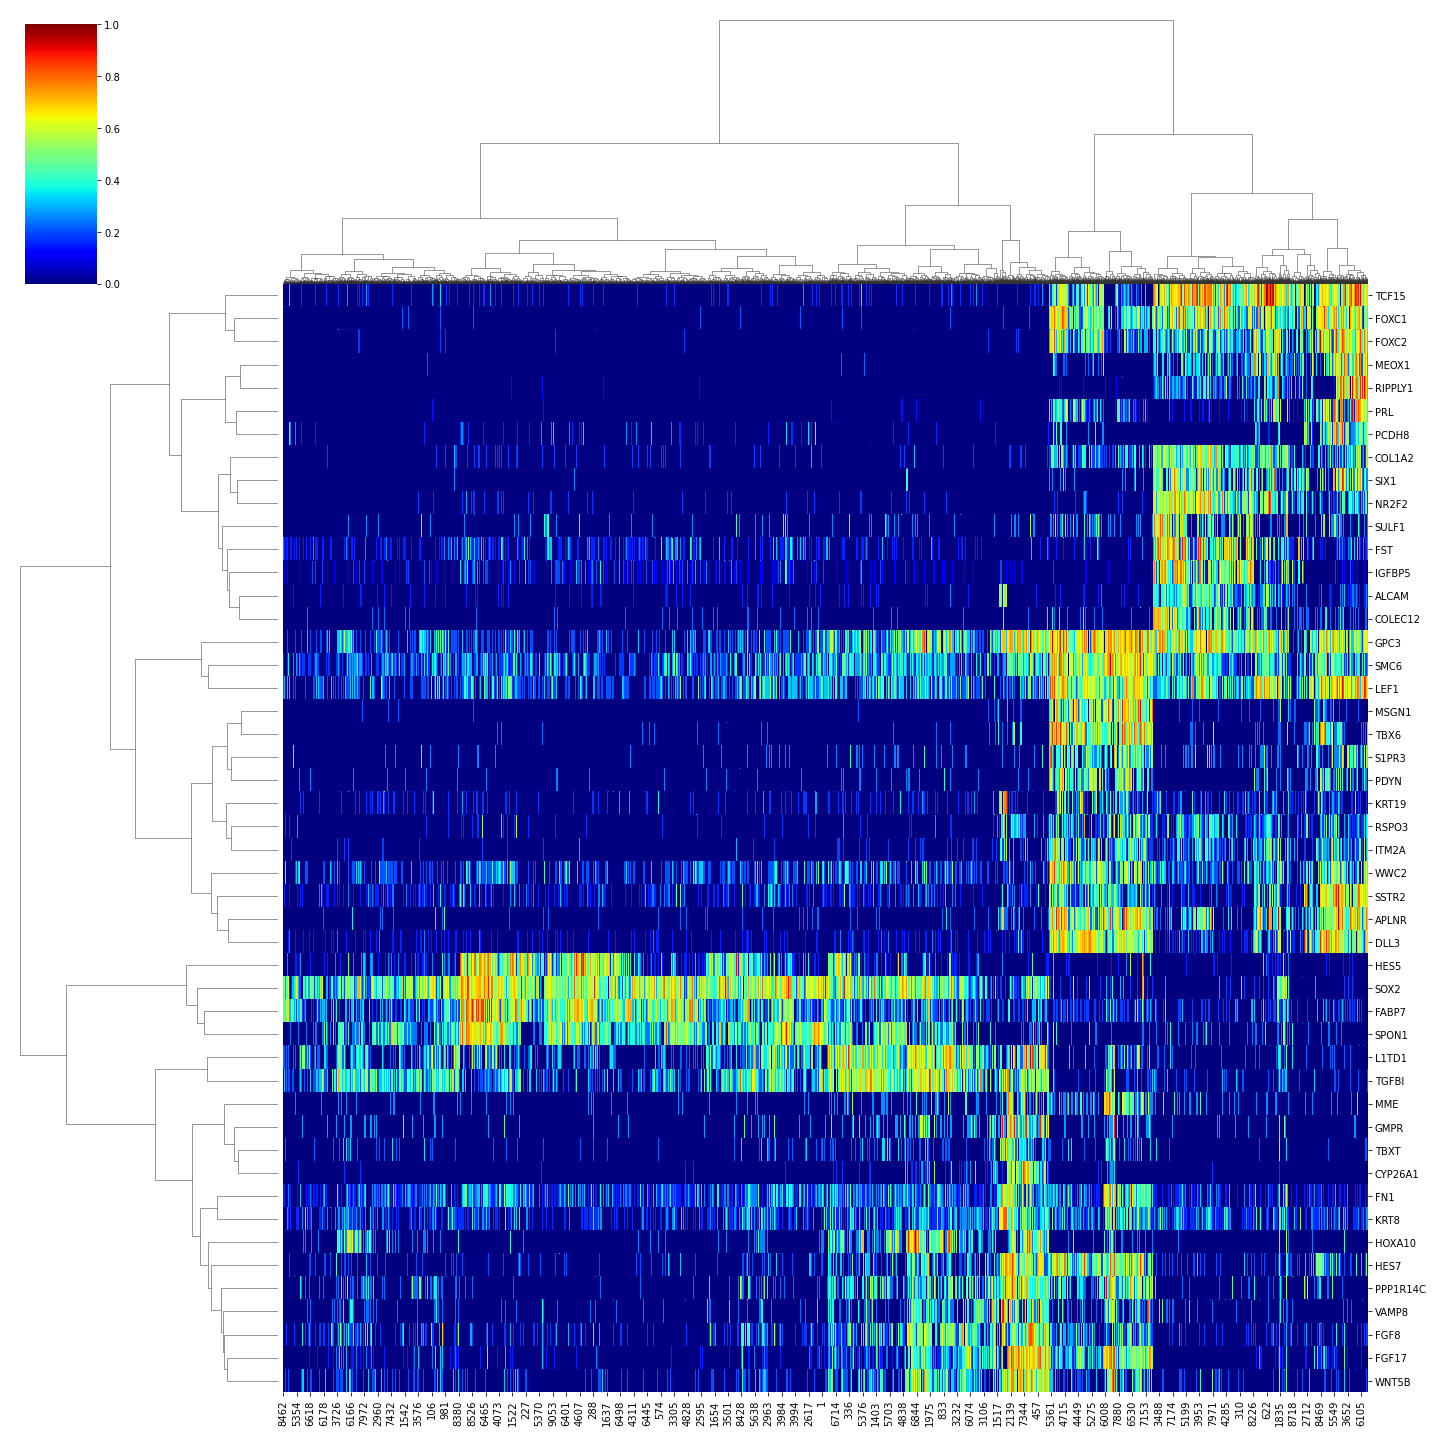

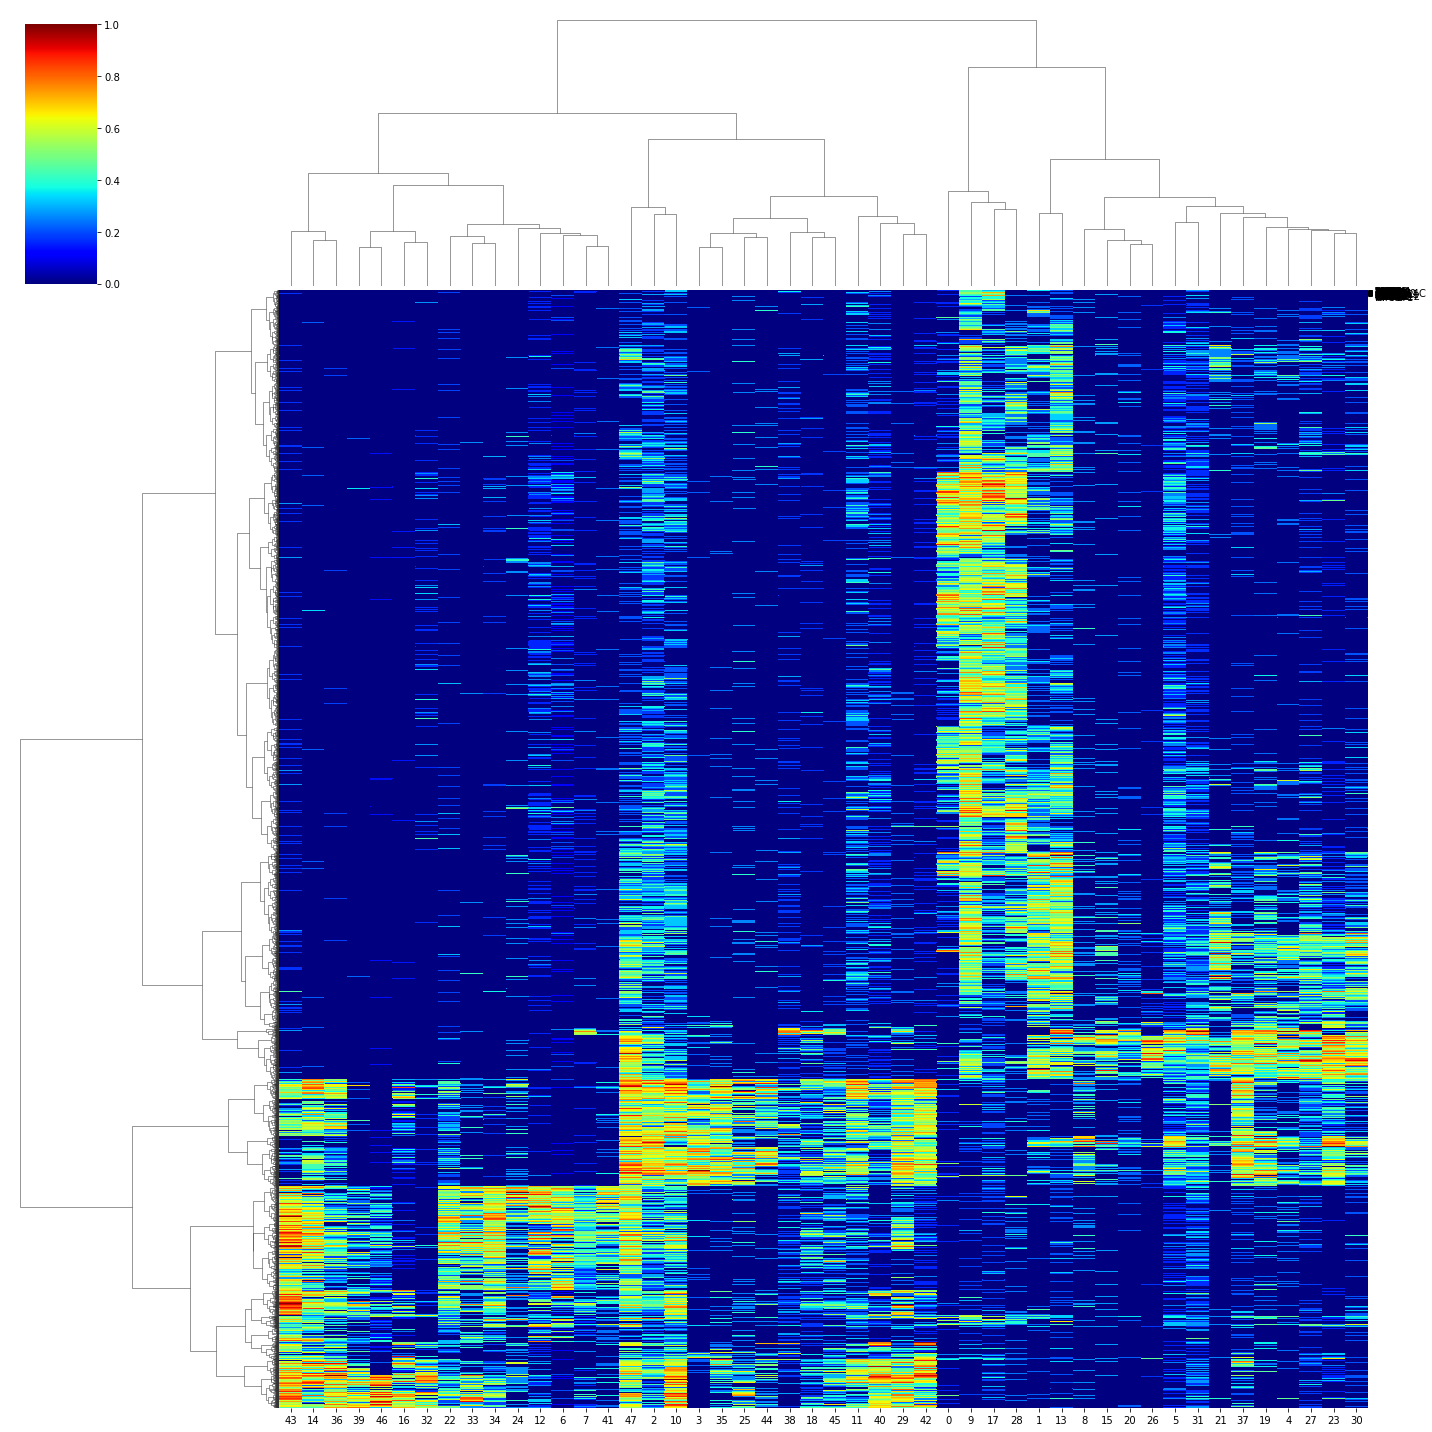

In [5]:
axv = sns.clustermap(clusterX.T, yticklabels=x[bimodal_genes], cmap='jet', figsize=(20,20), col_cluster=True,method='ward')
plt.show()
columns=axv.dendrogram_row.reordered_ind
geneNamesY=geneNames[columns]
axv = sns.clustermap(clusterX, yticklabels=x[bimodal_genes], cmap='jet', figsize=(20,20), col_cluster=True,method='ward')
columns=axv.dendrogram_row.reordered_ind

In [6]:
data = data[:,bimodal_genes2]

... storing 'feature_types' as categorical


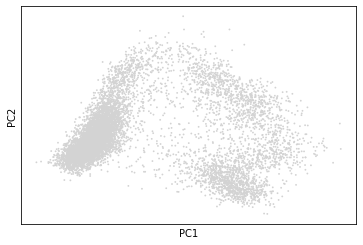

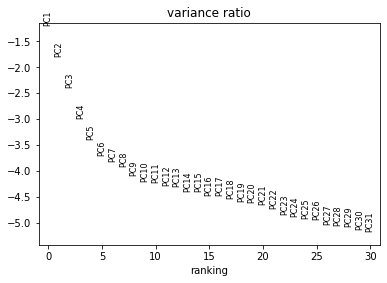

In [7]:
sc.tl.pca(data, svd_solver='arpack')
sc.pl.pca(data)
sc.pl.pca_variance_ratio(data, log=True)

In [8]:
sc.pp.neighbors(data, n_neighbors=30, n_pcs=30)
sc.tl.umap(data)

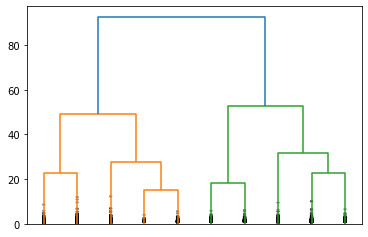

In [9]:
Z = linkage(clusterX, 'ward')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=10,  # show only the last p merged clusters
    show_leaf_counts=False,  # otherwise numbers in brackets are counts
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [10]:
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z,6, criterion='maxclust')
clusters_2 = fcluster(Z,10, criterion='maxclust')
clusters3=clusters
clusters3[clusters==5]=clusters3[clusters==5]+2
clusters3[clusters_2==4]=clusters3[clusters_2==4]+5
clusters=clusters3

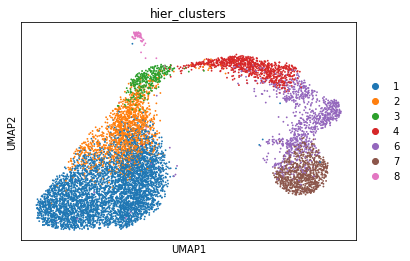

In [11]:
data.obs['hier_clusters']=pd.Categorical(clusters)
adata.obs['hier_clusters']=pd.Categorical(clusters)
sc.pl.umap(data, color='hier_clusters',cmap='jet')

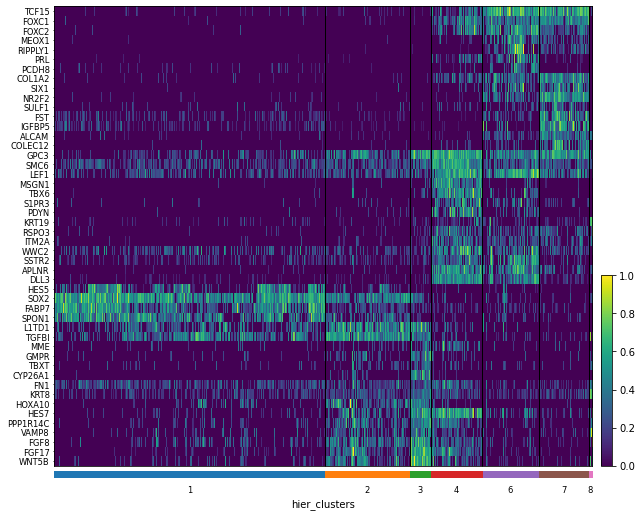

In [12]:
data.X=data.X.todense()
data2=data
data2=data2[columns,:]
data2.X=data2.X/np.std(data2.X,axis=0)
data2.X=data2.X-np.amin(data2.X,axis=0)
data2.X=data2.X/np.amax(data2.X,axis=0)
sc.pl.heatmap(data2,geneNamesY,groupby='hier_clusters', cmap='viridis',swap_axes=True,vmax=1,vmin=0)

In [13]:
geneNamesZ=['COL1A2', 'SIX1', 'NR2F2', 'SULF1', 'FST', 'IGFBP5', 'ALCAM',
       'COLEC12','TCF15', 'FOXC1', 'FOXC2', 'MEOX1', 'RIPPLY1', 'PRL', 'PCDH8','WWC2', 'SSTR2', 'APLNR',
       'DLL3',
       'GPC3', 'SMC6', 'LEF1', 'MSGN1', 'TBX6', 'S1PR3',
       'PDYN', 'KRT19', 'RSPO3', 'ITM2A',  'HES7',
       'PPP1R14C', 'VAMP8', 'FGF8', 'FGF17', 'WNT5B', 'MME',
       'GMPR', 'TBXT', 'CYP26A1', 'FN1', 'KRT8', 'HOXA10', 'HES5', 'SOX2', 'FABP7', 'SPON1', 'L1TD1', 'TGFBI']
cluster2annotation = {
     1: 'Anterior Neural Tube',
     2: 'Posterior Neural Tube',
     8: 'Notochord',
     3: 'Neuromesodermal Progenitor',
     4: 'Presomitic Mesoderm',     
     6: 'Early Somite',
     7: 'Somite'
    }
data2.obs['cell_type'] = data2.obs['hier_clusters'].map(cluster2annotation).astype('category')

Trying to set attribute `.obs` of view, copying.


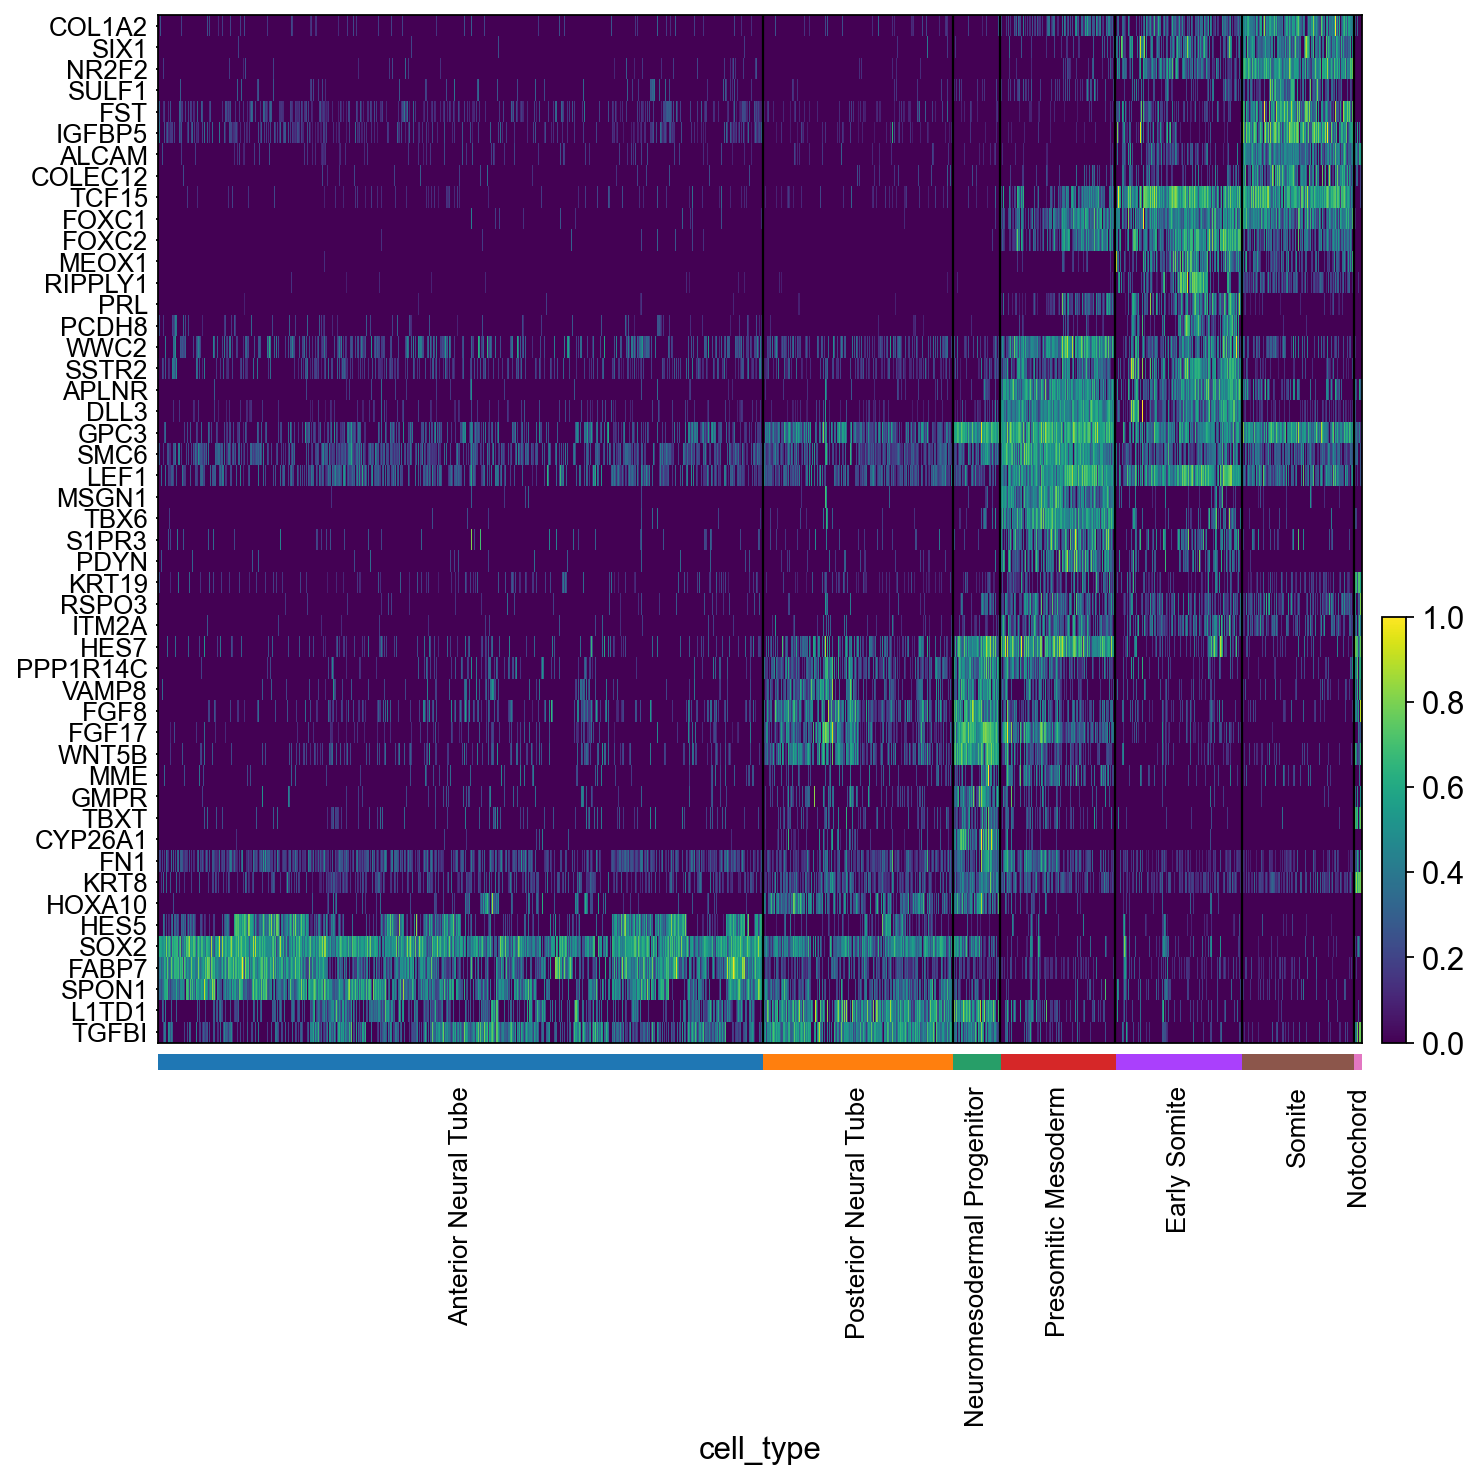

In [14]:
sc.set_figure_params(format='tif')
ax=sc.pl.heatmap(data2,geneNamesZ,'cell_type', cmap='viridis',swap_axes=True,vmax=1,vmin=0,save='heatmap_bluegreen.tif')

In [15]:
data2=data
data2=data2[columns,:]
data2.X=data2.X/np.std(data2.X,axis=0)
data2.X=data2.X-np.amin(data2.X,axis=0)
data2.X=data2.X/np.amax(data2.X,axis=0)

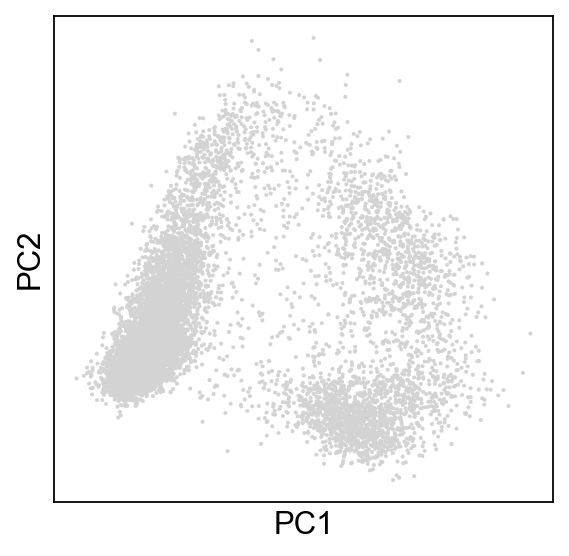

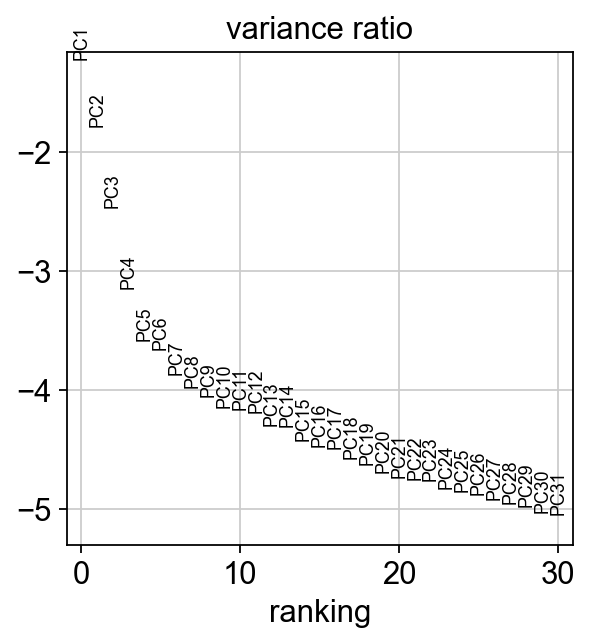

In [16]:
sc.tl.pca(data2, svd_solver='arpack')
sc.pl.pca(data2)
sc.pl.pca_variance_ratio(data2, log=True)
sc.pp.neighbors(data2, n_neighbors=30, n_pcs=30)
sc.tl.umap(data2)

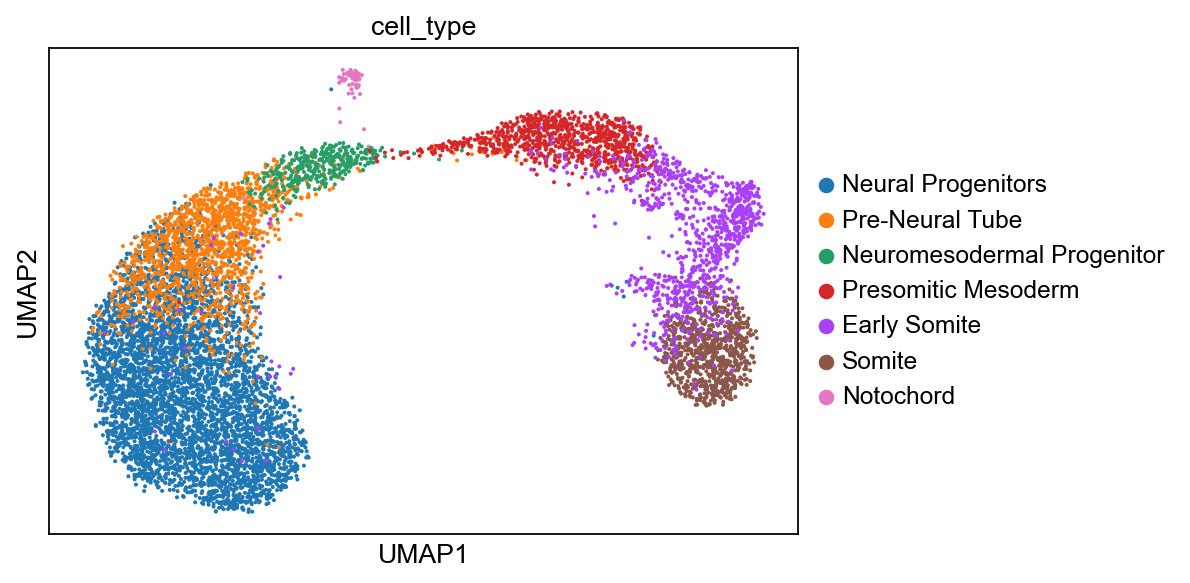

In [17]:
cluster2annotation = {
     1: 'Neural Progenitors',
     2: 'Pre-Neural Tube',
     8: 'Notochord',
     3: 'Neuromesodermal Progenitor',
     4: 'Presomitic Mesoderm',     
     6: 'Early Somite',
     7: 'Somite'
    }
data2.obs['cell_type'] = data2.obs['hier_clusters'].map(cluster2annotation).astype('category')
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=500, frameon=True, vector_friendly=False, fontsize=12, figsize=(6,4), color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')
sc.pl.umap(data2, color='cell_type',cmap='jet',save='seurat',title=None)

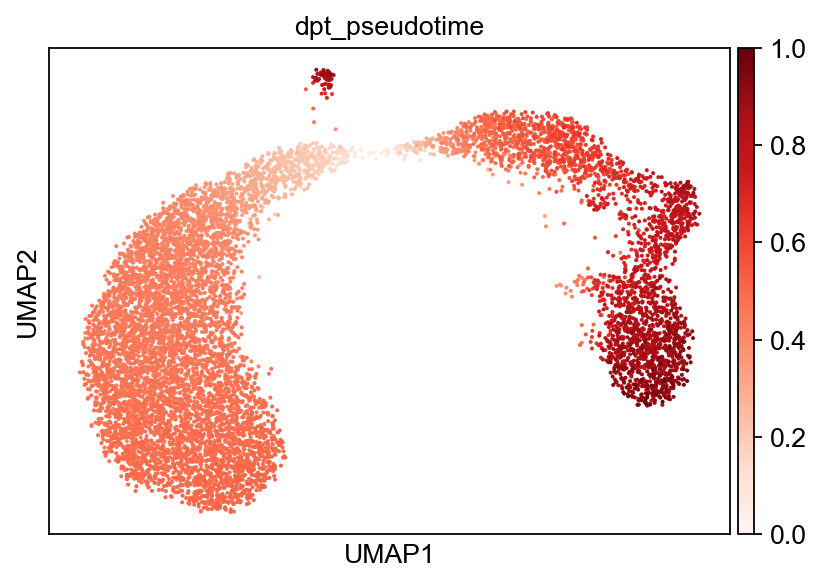

In [18]:
sc.tl.diffmap(data2)
sc.pp.neighbors(data2, n_neighbors=30, use_rep='X_diffmap')
data2.uns['iroot'] = np.flatnonzero(data2.obs['cell_type']  == 'Neuromesodermal Progenitor')[0]
sc.tl.dpt(data2)
sc.pl.umap(data2,color='dpt_pseudotime',vmax=1,save='pseudotime_umap1',cmap='Reds')

In [20]:
adata=adata[columns,:]
adata.obs['dpt_pseudotime']=data2.obs['dpt_pseudotime']
adata.uns['umap']=data2.uns['umap']
adata.obsm['X_umap']=data2.obsm['X_umap']
adata.obs['Cell_Type']=data2.obs['cell_type']

Trying to set attribute `.obs` of view, copying.


In [ ]:
adata.write('adata.h5ad')